In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Define data transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to [0,1] range tensors
])

In [4]:
# Load training and test datasets
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False
)

100%|██████████| 9.91M/9.91M [00:11<00:00, 896kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.28MB/s]


![image](https://raw.githubusercontent.com/E008001/Autoencoder-in-Pytorch/main/structure-Convolutional-AutoEncoders.png)

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Convolutional layers
        self.conv_encoder = nn.Sequential(
            # Input: (batch_size, 1, 28, 28)
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, stride=2, padding=0),
            # Output: (batch_size, 32, 14, 14)
            nn.ReLU(True),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2, padding=0),
            # Output: (batch_size, 64, 7, 7)
            nn.ReLU(True),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=0),
            # Output: (batch_size, 128, 3, 3)
            nn.ReLU(True)
        )

        # Fully connected layer (after flattening)
        # The input features to this layer will be 128 * 3 * 3 = 1152
        self.fc_encoder = nn.Linear(in_features=128 * 3 * 3, out_features=16)

        # --- Decoder ---
        # Fully connected layer (before reshaping)
        self.fc_decoder = nn.Linear(in_features=16, out_features=128 * 3 * 3)

        # Deconvolutional (Transposed Convolutional) layers
        self.deconv_decoder = nn.Sequential(
            # Input after reshape: (batch_size, 128, 3, 3)
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=0, output_padding=0),
            # Output: (batch_size, 64, 7, 7)
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2, padding=0, output_padding=0),
            # Output: (batch_size, 32, 14, 14)
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=2, padding=0, output_padding=0),
            # Output: (batch_size, 1, 28, 28)
            nn.Sigmoid() # Sigmoid to ensure output values are between 0 and 1
        )

    def forward(self, x):
        # Encoder pass
        x = self.conv_encoder(x)

        # Flatten the output of conv_encoder for the FC layer
        # x.size(0) is the batch size
        batch_size = x.size(0)
        x = x.view(batch_size, -1) # Flatten

        encoded = self.fc_encoder(x) # This is the latent space representation 'h'

        # Decoder pass
        x = self.fc_decoder(encoded)

        # Reshape the output of fc_decoder to be suitable for deconv_decoder
        # Target shape: (batch_size, 128, 3, 3)
        x = x.view(batch_size, 128, 3, 3) # Reshape

        decoded = self.deconv_decoder(x) # Reconstructed image

        return decoded

In [6]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()  # Reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [8]:
num_epochs = 20
train_losses = []

print("Starting training...")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_idx, (images, _) in enumerate(train_loader):
        # Move data to device
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update statistics
        epoch_loss += loss.item() * images.size(0)

    # Calculate average epoch loss
    avg_epoch_loss = epoch_loss / len(train_dataset)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

print("Training finished.")

Starting training...
Epoch [1/20], Loss: 0.0087
Epoch [2/20], Loss: 0.0086
Epoch [3/20], Loss: 0.0085
Epoch [4/20], Loss: 0.0084
Epoch [5/20], Loss: 0.0083
Epoch [6/20], Loss: 0.0082
Epoch [7/20], Loss: 0.0081
Epoch [8/20], Loss: 0.0080
Epoch [9/20], Loss: 0.0080
Epoch [10/20], Loss: 0.0079
Epoch [11/20], Loss: 0.0078
Epoch [12/20], Loss: 0.0078
Epoch [13/20], Loss: 0.0077
Epoch [14/20], Loss: 0.0077
Epoch [15/20], Loss: 0.0076
Epoch [16/20], Loss: 0.0076
Epoch [17/20], Loss: 0.0076
Epoch [18/20], Loss: 0.0075
Epoch [19/20], Loss: 0.0075
Epoch [20/20], Loss: 0.0075
Training finished.


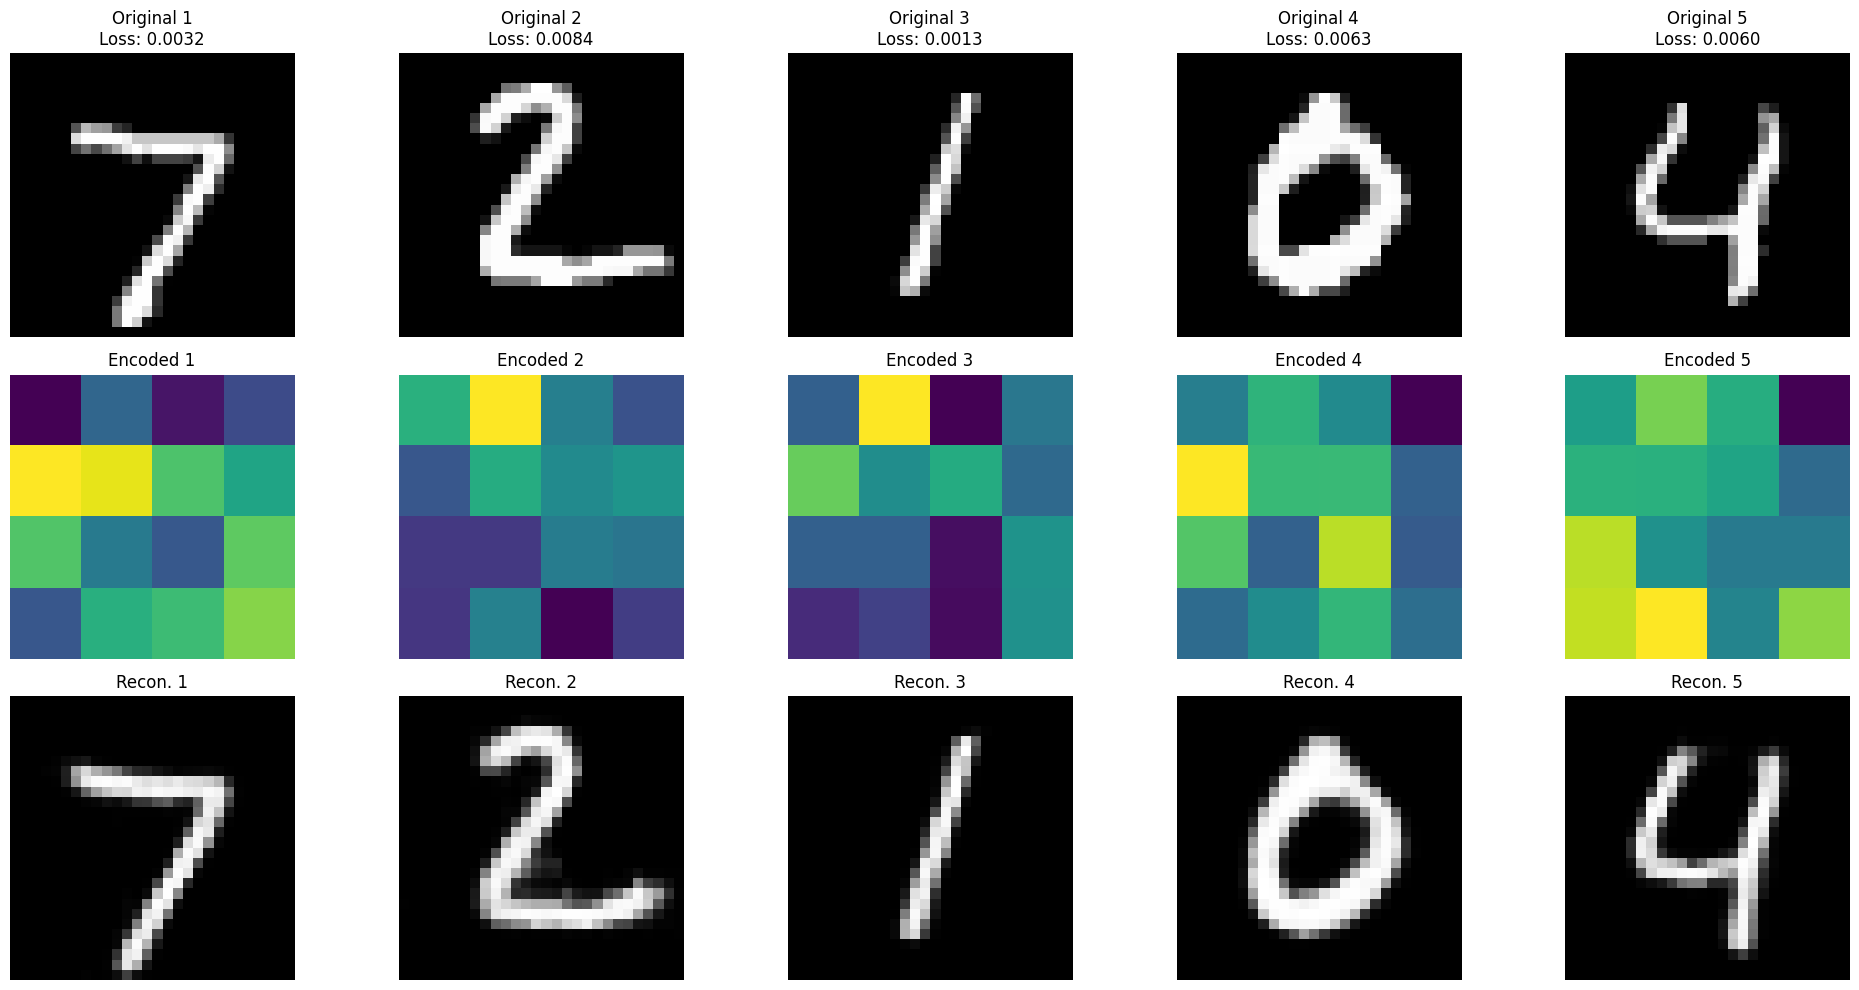

In [13]:
# Define a criterion for per-image loss calculation
per_image_criterion = nn.MSELoss(reduction='none')

# Calculate the MSE loss for each of the 5 images using reduction='none'
# This will give us a tensor of shape (batch_size, 1, 28, 28)
per_pixel_squared_error = per_image_criterion(reconstructed, images_to_show)

# Now, sum the squared errors over the image dimensions (channel, height, width)
# and then take the mean over these dimensions to get per-image loss
# Original shape: (batch_size, 1, 28, 28)
# Sum over dimensions 1, 2, 3
per_image_loss = torch.mean(per_pixel_squared_error, dim=(1, 2, 3))
# per_image_loss will be a tensor of shape (batch_size,)

# Convert tensors to numpy arrays
original_np = images_to_show.squeeze().cpu().numpy()
reconstructed_np = reconstructed.squeeze().cpu().numpy()
encoded_np = encoded_vectors.squeeze().cpu().numpy() # Convert encoded vectors to numpy
# Convert the per-image loss tensor to numpy
per_image_loss_np = per_image_loss.cpu().numpy()

# Create plot using the specified subplot layout
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))

for i in range(5):
    # Original image (first row)
    axes[0, i].imshow(original_np[i], cmap='gray')
    axes[0, i].set_title(f'Original {i+1}\nLoss: {per_image_loss_np[i]:.4f}') # Add loss to title from numpy array
    axes[0, i].axis('off')

    # Encoded (reshaped) image (second row)
    # Reshape the current encoded vector (which is 64 elements) to 8x8
    encoded_reshaped = encoded_np[i].reshape(4, 4)
    axes[1, i].imshow(encoded_reshaped, cmap='viridis') # Using viridis colormap
    axes[1, i].set_title(f'Encoded {i+1}')
    axes[1, i].axis('off')

    # Reconstructed image (third row)
    axes[2, i].imshow(reconstructed_np[i], cmap='gray')
    axes[2, i].set_title(f'Recon. {i+1}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()